In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import genfromtxt
from scipy.optimize import linprog
plt.rcParams['figure.figsize'] = [10, 10]

### Generating Data
Here, I generate 2D data as follows: 
I pick a center $(x_c, y_c)$ where $x_c, y_c \sim N(0, 1)$ and a radius $r \sim N(1, 1)$.

1. If $\|x_i - x_c\|_2 \leq r$, then $y_i = +1$
2. If $\|x_i - x_c\|_2 > r$, then $y_i = -1$

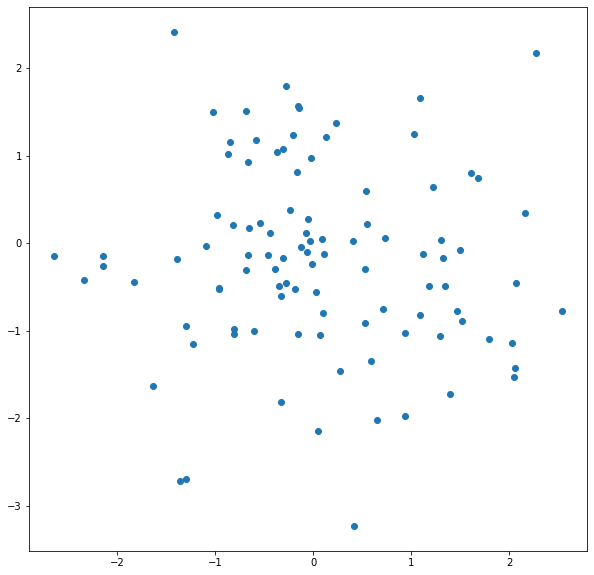

In [26]:
data = np.random.multivariate_normal(np.zeros(2), np.identity(2), 100)
plt.scatter(data[:, 0], data[:, 1])

In [27]:
xc = np.random.normal(0, 1, 2)
r = np.random.normal(1, 1, 1)[0]
xc, r

(array([ 0.09815188, -0.56428166]), 1.4381049883604076)

In [28]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

def color(x):
    return 1 if np.linalg.norm(x - xc, 2) <= r else -1

In [29]:
c = np.apply_along_axis(color, 1, data)
c

array([-1, -1, -1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1,
        1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,
       -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,
        1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1, -1,
        1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1])

In [30]:
def color_to_string(x):
    if x == 1: return "r"
    else: return "b"
np.vectorize(color_to_string)(c)

array(['b', 'b', 'b', 'r', 'b', 'r', 'r', 'b', 'r', 'b', 'r', 'r', 'r',
       'r', 'b', 'r', 'b', 'r', 'r', 'b', 'b', 'b', 'r', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'r', 'r', 'b', 'r', 'b', 'r', 'b', 'b', 'b',
       'b', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'b', 'r', 'r', 'b', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'b', 'r',
       'b', 'b', 'b', 'r', 'b', 'r', 'r', 'r', 'b', 'b', 'r', 'b', 'r',
       'r', 'b', 'b', 'r', 'r', 'b', 'b', 'r', 'r', 'b', 'b', 'b', 'b',
       'r', 'b', 'r', 'r', 'r', 'b', 'r', 'r', 'b'], dtype='<U1')

### Kernelized SVM
The current situation is that, no matter what hyperplane we choose, we are unable to get a satisfactory separator i.e. we can do not much better than just randomly guessing.

The trick here is to transform our data (which now resides in $\mathbb{R}^2$) into a higher dimension, say $\mathbb{R}^d$, and hope that in this higher dimension, there is a hyperplane (which has dimension $\mathbb{R}^{d-1}$) that separates the classes.

For every data $x_i$, I append the square of the $l_2$ norm of $x_i$ to it as a feature. This is based on the knowledge that the underlying model is circular.

In [62]:
n = np.apply_along_axis(lambda x: np.linalg.norm(x, 2)**2, 1, data)
data = np.concatenate((data, n.reshape(-1, 1)), axis=1)
data[0:5]

array([[-2.64350951, -0.14394507,  7.00886271, 56.13301926],
       [-1.63648348, -1.62789887,  5.32813292, 33.71713332],
       [-1.3901046 , -0.18195747,  1.96549933,  5.82868695],
       [ 0.7108793 , -0.75164392,  1.07031795,  2.21589847],
       [-0.27930117,  1.79914723,  3.31493988, 14.3037663 ]])

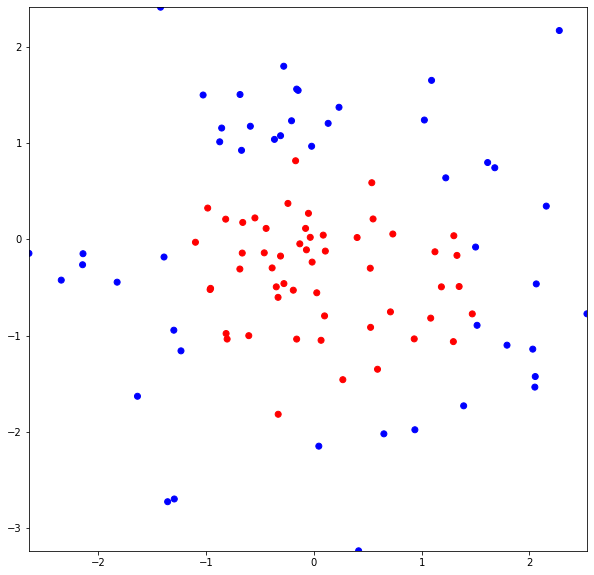

In [63]:
plt.scatter(data[:,0], data[:,1], c=np.vectorize(color_to_string)(c))
plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
plt.show()

In [64]:
what = cp.Variable(3)
bhat = cp.Variable(1)
ehat = cp.Variable(data.shape[0])

objective = cp.Minimize(cp.sum_squares(what) + cp.norm(ehat, 1))
constraints = []
for i in range(len(data)):
    yi = c[i]
    xi = data[i][0:3]
    constraints += [-yi*(xi[0]*what[0] + xi[1]*what[1] + xi[2]*what[2] + bhat) - ehat[i] + 1 <= 0]
constraints += [-ehat <= 0]

In [65]:
problem = cp.Problem(objective, constraints)
result = problem.solve()
what.value, bhat.value, ehat.value

(array([ 0.61408392, -1.38969869, -1.53809978]),
 array([2.70975643]),
 array([-4.90254064e-08, -7.09177697e-08,  8.58512270e-02,  1.76090690e-07,
        -1.40592714e-07,  2.13320978e-07,  2.07067730e-07, -5.60584444e-08,
        -9.57709884e-06, -2.31419432e-07,  1.62449089e-07,  2.03788893e-07,
         2.09219993e-07, -7.55820234e-06, -2.18265273e-07,  2.05593730e-07,
        -2.34332549e-07,  1.99597264e-07,  2.03861299e-07, -2.25279754e-07,
        -1.32617497e-07, -2.06398064e-07,  5.56386762e-01, -1.62734737e-08,
         1.12819502e+00, -4.13947980e-08, -3.06704137e-08, -4.39269649e-08,
        -2.34946353e-07, -2.36957461e-08,  1.62708505e-07,  1.63533512e-07,
        -9.79650613e-08,  1.90738118e-07, -2.11594705e-07,  1.00457075e+00,
        -1.94967715e-07, -1.97222461e-08,  9.09188139e-01, -6.29471125e-08,
         2.07746695e-07,  2.10031079e-07,  2.14688774e-07,  2.02954697e-07,
         1.83585418e-01, -1.84695068e-07,  1.98696729e-07, -1.32987595e-07,
         2.215406

### Results

In [66]:
def prediction(x):
    return '#96CFFF' if what.value[0]*x[0] + what.value[1]*x[1] + what.value[2]*(np.linalg.norm(x, 2)**2) + bhat.value < 0 else '#FFA996'

In [67]:
a, b = np.mgrid[-6:6:0.1, -6:6:0.1]
a = a.flatten()
b = b.flatten()
graphx = np.column_stack((a, b))
cc = np.apply_along_axis(prediction, 1, graphx)

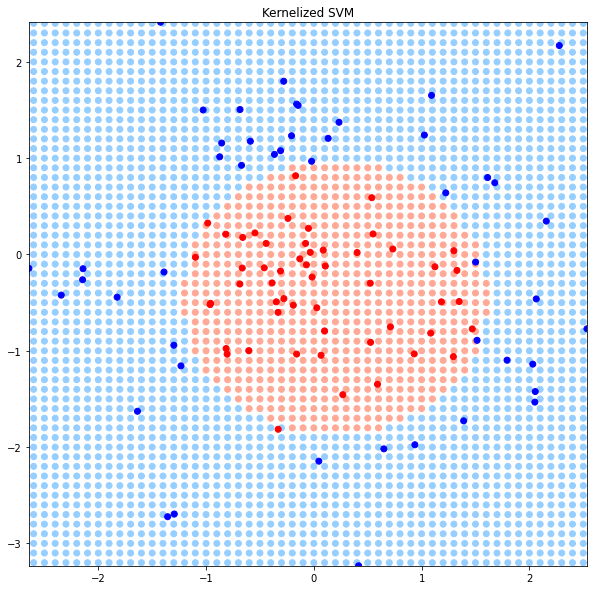

In [68]:
plt.scatter(a, b, c=cc)
plt.scatter(data[:,0], data[:,1], c=np.vectorize(color_to_string)(c))
plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
plt.title("Kernelized SVM")
plt.show()